In [2]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
from ComputeLCLpressure_DSfunction import ComputeLCLpressure
import glob 
import dask


# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Define some useful functions

In [31]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


In [2]:
# from dask.distributed import Client, progress
# client = Client(threads_per_worker=4, n_workers=2)
# client 

Client Scheduler: tcp://127.0.0.1:37259 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 8 Memory: 10.74 GB


## Read in files

**Update** It's still weirdly slow to try using Dask, so timeseries files created previously

In [27]:
dataDir = '/glade/work/mdfowler/data/temp_staging/'

ATMfile_case1 = dataDir+'cam6clm50sp_cesm23a02cPPEn08ctsm51d030_1deg_hist.cam.h1.1980-1988_CIvars.nc'
ATMfile_case2 = dataDir+'cam6ctsm51sp_cesm23a02cPPEn08ctsm51d030_1deg_hist.cam.h1.1980-1988_CIvars.nc'
LNDfile_case1 = dataDir+'cam6clm50sp_cesm23a02cPPEn08ctsm51d030_1deg_hist.clm2.h4.1980-1988_CIvars.nc'
LNDfile_case2 = dataDir+'cam6ctsm51sp_cesm23a02cPPEn08ctsm51d030_1deg_hist.clm2.h4.1980-1988_CIvars.nc'

with xr.open_dataset(ATMfile_case1, decode_times=True) as ATM_case1_DS: 
    ATM_case1_DS['time'] = ATM_case1_DS.indexes['time'].to_datetimeindex()
    
with xr.open_dataset(ATMfile_case2, decode_times=True) as ATM_case2_DS: 
    ATM_case2_DS['time'] = ATM_case2_DS.indexes['time'].to_datetimeindex()

with xr.open_dataset(LNDfile_case1, decode_times=True) as LND_case1_DS:
    LND_case1_DS['time'] = LND_case1_DS.indexes['time'].to_datetimeindex()
    
with xr.open_dataset(LNDfile_case2, decode_times=True) as LND_case2_DS:
    LND_case2_DS['time'] = LND_case2_DS.indexes['time'].to_datetimeindex()
    

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if __name__ == '__main__':
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if sys.path[0] == '':
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  T

The file formats in the cell below are the main section that will need to be modified for each run:

In [65]:
# Define directory where files are saved (usually on /glade/scratch)
dataDir = '/glade/scratch/oleson/archive/'

# Define two casenames to compare 
case1 = 'cam6clm50sp_cesm23a02cPPEn08ctsm51d030_1deg_hist'
case2 = 'cam6ctsm51sp_cesm23a02cPPEn08ctsm51d030_1deg_hist'

# Define which history files the necessary *daily* atm and lnd variables are saved in
histFileNum_clm = '4'
histFileNum_cam = '1'

# Get list of files to read data for 
#   NOTE: This section should be modified to use a start year and end year 
#         rather than a hard coded 198*
# ATMfiles_case1 = sorted(glob.glob(dataDir+case1+'/atm/hist/'+case1+'.cam.h'+histFileNum_cam+'.198*'))
# ATMfiles_case2 = sorted(glob.glob(dataDir+case2+'/atm/hist/'+case2+'.cam.h'+histFileNum_cam+'.198*'))

# LNDfiles_case1 = sorted(glob.glob(dataDir+case1+'/lnd/hist/'+case1+'.clm2.h'+histFileNum_clm+'.198*'))
# LNDfiles_case2 = sorted(glob.glob(dataDir+case2+'/lnd/hist/'+case2+'.clm2.h'+histFileNum_clm+'.198*'))


In [19]:
## Define some plotting keywords so that all cells can be executed at once, 
#    and only plots that are desired are plotted 

# Plot the raw atm/terr segments of the coupling index as computed
plt_rawMaps = 'true'

# Plot the difference in the atm/terr CI as ** case2 - case1 **
plt_diffMaps = 'true'

# Plot zonal means of the atm/terr CI
plt_zonalMeans = 'true'



Now use xarray's open_mfdataset and dask to open all those daily files at once, rather than creating a timeseries file first using NCO (ncrcat). <br>
This section should **NOT** need to be modified by the user.

In [5]:
# ATM_case1_DS = xr.open_mfdataset(
#         ATMfiles_case1,
#         # Name of the dimension to concatenate along.
#         concat_dim="time",

#         # Attempt to auto-magically combine the given datasets into one by using dimension coordinates.
#         combine="by_coords",

#         # Specify chunks for dask - explained later
#         chunks={"lev": 1, "time": 500},

#         # Only data variables in which the dimension already appears are included.
#         data_vars="minimal",

#         # Only coordinates in which the dimension already appears are included.
#         coords="minimal",

#         # Skip comparing and pick variable from first dataset.
#         compat="override",
#         parallel=True,
#     )


In [6]:
# ATM_case2_DS = xr.open_mfdataset(
#         ATMfiles_case2,
#         # Name of the dimension to concatenate along.
#         concat_dim="time",

#         # Attempt to auto-magically combine the given datasets into one by using dimension coordinates.
#         combine="by_coords",

#         # Specify chunks for dask - explained later
#         chunks={"lev": 1, "time": 500},

#         # Only data variables in which the dimension already appears are included.
#         data_vars="minimal",

#         # Only coordinates in which the dimension already appears are included.
#         coords="minimal",

#         # Skip comparing and pick variable from first dataset.
#         compat="override",
#         parallel=True,
#     )

In [7]:
# LND_case1_DS = xr.open_mfdataset(
#         LNDfiles_case1,
#         # Name of the dimension to concatenate along.
#         concat_dim="time",

#         # Attempt to auto-magically combine the given datasets into one by using dimension coordinates.
#         combine="by_coords",

#         # Specify chunks for dask - explained later
#         chunks={"levsoi": 1, "time": 500},

#         # Only data variables in which the dimension already appears are included.
#         data_vars="minimal",

#         # Only coordinates in which the dimension already appears are included.
#         coords="minimal",

#         # Skip comparing and pick variable from first dataset.
#         compat="override",
#         parallel=True,
#     )


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 20
  **blockwise_kwargs,
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 20
  **blockwise_kwargs,
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 20
  **blockwise_kwargs,


In [8]:
# LND_case2_DS = xr.open_mfdataset(
#         LNDfiles_case2,
#         # Name of the dimension to concatenate along.
#         concat_dim="time",

#         # Attempt to auto-magically combine the given datasets into one by using dimension coordinates.
#         combine="by_coords",

#         # Specify chunks for dask - explained later
#         chunks={"levsoi": 1, "time": 500},

#         # Only data variables in which the dimension already appears are included.
#         data_vars="minimal",

#         # Only coordinates in which the dimension already appears are included.
#         coords="minimal",

#         # Skip comparing and pick variable from first dataset.
#         compat="override",
#         parallel=True,
#     )



/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 20
  **blockwise_kwargs,
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 20
  **blockwise_kwargs,
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 20
  **blockwise_kwargs,


## Drop unwanted variables

In [9]:
# ATMvars_keep = np.asarray(['LHFLX','SHFLX','PS','TREFHT','RHREFHT'])
# LNDvars_keep = np.asarray(['SOILWATER_10CM','landmask'])

# ATM_case1_DS = ATM_case1_DS[ATMvars_keep]
# ATM_case2_DS = ATM_case2_DS[ATMvars_keep]

# LND_case1_DS = LND_case1_DS[LNDvars_keep]
# LND_case2_DS = LND_case2_DS[LNDvars_keep]


Load the dask arrays into memory (limited variables, shouldn't take up much space). But this is *shockingly* slow too, so something to be aware of. I'm wondering if it would still be better to just create timeseries files...

In [12]:
# ATM_case1_DS = ATM_case1_DS.load()
# ATM_case2_DS = ATM_case2_DS.load()
# LND_case1_DS = LND_case1_DS.load()
# LND_case2_DS = LND_case2_DS.load()


KeyboardInterrupt: 

## Compute the pressure level of the LCL
**Note:** Computing the pressure level of the LCL in these large arrays is by large the longest part of this script. As currently implemented, this takes upwards of 10-20 minutes *per case*. There's a huge opportunity here for speeding things up, likely using dask. 

In [22]:
Plcl_case1 = ComputeLCLpressure(ATM_case1_DS,'PS','TREFHT','RHREFHT')

Plcl_case2 = ComputeLCLpressure(ATM_case2_DS,'PS','TREFHT','RHREFHT')


Data starts at:  1980-01-26 00:00:00
Data ends at:    1989-01-01 00:00:00
Done with  0.0  % of days
Done with  9.996933455995094  % of days
Done with  19.99386691199019  % of days
Done with  29.990800367985283  % of days
Done with  39.98773382398038  % of days
Done with  49.98466727997547  % of days
Done with  59.98160073597057  % of days
Done with  69.97853419196566  % of days
Done with  79.97546764796076  % of days
Done with  89.97240110395585  % of days
Done with  99.96933455995094  % of days
Data starts at:  1980-01-26 00:00:00
Data ends at:    1989-01-01 00:00:00
Done with  0.0  % of days
Done with  9.996933455995094  % of days
Done with  19.99386691199019  % of days
Done with  29.990800367985283  % of days
Done with  39.98773382398038  % of days
Done with  49.98466727997547  % of days
Done with  59.98160073597057  % of days
Done with  69.97853419196566  % of days
Done with  79.97546764796076  % of days
Done with  89.97240110395585  % of days
Done with  99.96933455995094  % of day

## Compute the atmospheric and terrestrial legs of the coupling index

In [24]:
# First define the land mask 
testFile = '/glade/scratch/oleson/archive/cam6clm50sp_cesm23a02cPPEn08ctsm51d030_1deg_hist/lnd/hist/cam6clm50sp_cesm23a02cPPEn08ctsm51d030_1deg_hist.clm2.h4.1988-12-12-00000.nc'
testDS = xr.open_dataset(testFile,decode_times=True)

landMask              = testDS.landmask.values.astype(float)
landMask[landMask==0] = np.nan


In [28]:
# Make one big xr.Dataset containing all the information we need  
dsFull_case1 = ATM_case1_DS
dsFull_case1['soilM_10'] = (('time','lat','lon'), LND_case1_DS.SOILWATER_10CM.values)
dsFull_case1['Plcl'] = (('time','lat','lon'), Plcl_case1)
 
dsFull_case2 = ATM_case2_DS
dsFull_case2['soilM_10'] = (('time','lat','lon'), LND_case2_DS.SOILWATER_10CM.values)
dsFull_case2['Plcl'] = (('time','lat','lon'), Plcl_case2)


In [29]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_case1 = cm.metrics.CouplingIndex()
terraLeg_case1 = terraLeg_case1.compute(dsFull_case1, xname='soilM_10',yname='SHFLX',averaging='season')

terraLeg_case2 = cm.metrics.CouplingIndex()
terraLeg_case2 = terraLeg_case2.compute(dsFull_case2, xname='soilM_10',yname='SHFLX',averaging='season')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [30]:
# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_case1 = cm.metrics.CouplingIndex()
atmoLeg_case1 = atmoLeg_case1.compute(dsFull_case1, xname='SHFLX',yname='Plcl',averaging='season')

atmoLeg_case2 = cm.metrics.CouplingIndex()
atmoLeg_case2 = atmoLeg_case2.compute(dsFull_case2, xname='SHFLX',yname='Plcl',averaging='season')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Make plots as requested

Set up colormaps

In [32]:
### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB
my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)


### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPlcl = [(172,183,209), 
                       (124,135,181),
                       (51,82,120),
                       (97,181,89),
                       (200,218,102),
                       (255,242,116),
                       (238,164,58),
                       (136,90,59),
                       (214,48,44),
                       (224,93,126),
                       (242,189,177)] # This example uses the 8-bit RGB
my_cmap_SHFvPlcl = make_cmap(colorsList_SHFvPlcl, bit=True)


In [33]:
# Define lat and lon 
lat = terraLeg_case1.lat.values
lon = terraLeg_case1.lon.values


In [85]:
# Now get color coded arrays 
colorsAtmoLeg_case1  = np.full([4, len(lat),len(lon)],np.nan)
colorsTerraLeg_case1 = np.full([4, len(lat),len(lon)],np.nan)
colorsAtmoLeg_case2  = np.full([4, len(lat),len(lon)],np.nan)
colorsTerraLeg_case2 = np.full([4, len(lat),len(lon)],np.nan)

# ----- CASE 1 ------

# Atmo leg 
colorsAtmoLeg_case1[np.where(atmoLeg_case1.SHFLX_Plcl_CI.values<-150)]                                 = 1
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>-150) & (atmoLeg_case1.SHFLX_Plcl_CI.values<=-100))]  = 2
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>-100) & (atmoLeg_case1.SHFLX_Plcl_CI.values<=-50))]   = 3
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>-50)  & (atmoLeg_case1.SHFLX_Plcl_CI.values<=-20))]   = 4
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>-20)  & (atmoLeg_case1.SHFLX_Plcl_CI.values<=0))]     = 5
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>0)    & (atmoLeg_case1.SHFLX_Plcl_CI.values<=20))]    = 6
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>20)   & (atmoLeg_case1.SHFLX_Plcl_CI.values<=40))]    = 7
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>40)   & (atmoLeg_case1.SHFLX_Plcl_CI.values<=60))]    = 8
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>60)   & (atmoLeg_case1.SHFLX_Plcl_CI.values<=80))]    = 9
colorsAtmoLeg_case1[np.where((atmoLeg_case1.SHFLX_Plcl_CI.values>80)   & (atmoLeg_case1.SHFLX_Plcl_CI.values<=100))]   = 10
colorsAtmoLeg_case1[np.where(atmoLeg_case1.SHFLX_Plcl_CI.values>100)]                                  = 11


# Terra leg  
colorsTerraLeg_case1[np.where(terraLeg_case1.soilM_10_SHFLX_CI.values<-20)]                                 = 1
colorsTerraLeg_case1[np.where((terraLeg_case1.soilM_10_SHFLX_CI.values>-20) & (terraLeg_case1.soilM_10_SHFLX_CI.values<=-15))]  = 2
colorsTerraLeg_case1[np.where((terraLeg_case1.soilM_10_SHFLX_CI.values>-15) & (terraLeg_case1.soilM_10_SHFLX_CI.values<=-10))]  = 3
colorsTerraLeg_case1[np.where((terraLeg_case1.soilM_10_SHFLX_CI.values>-10) & (terraLeg_case1.soilM_10_SHFLX_CI.values<=-5))]   = 4
colorsTerraLeg_case1[np.where((terraLeg_case1.soilM_10_SHFLX_CI.values>-5) & (terraLeg_case1.soilM_10_SHFLX_CI.values<=-2))]    = 5
colorsTerraLeg_case1[np.where((terraLeg_case1.soilM_10_SHFLX_CI.values>-2) & (terraLeg_case1.soilM_10_SHFLX_CI.values<=-1))]    = 6
colorsTerraLeg_case1[np.where((terraLeg_case1.soilM_10_SHFLX_CI.values>-1) & (terraLeg_case1.soilM_10_SHFLX_CI.values<=0))]     = 7
colorsTerraLeg_case1[np.where(terraLeg_case1.soilM_10_SHFLX_CI.values>0)]                                   = 8

# ----- CASE 2 ------

# Atmo leg 
colorsAtmoLeg_case2[np.where(atmoLeg_case2.SHFLX_Plcl_CI.values<-150)]                                 = 1
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>-150) & (atmoLeg_case2.SHFLX_Plcl_CI.values<=-100))]  = 2
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>-100) & (atmoLeg_case2.SHFLX_Plcl_CI.values<=-50))]   = 3
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>-50)  & (atmoLeg_case2.SHFLX_Plcl_CI.values<=-20))]   = 4
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>-20)  & (atmoLeg_case2.SHFLX_Plcl_CI.values<=0))]     = 5
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>0)    & (atmoLeg_case2.SHFLX_Plcl_CI.values<=20))]    = 6
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>20)   & (atmoLeg_case2.SHFLX_Plcl_CI.values<=40))]    = 7
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>40)   & (atmoLeg_case2.SHFLX_Plcl_CI.values<=60))]    = 8
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>60)   & (atmoLeg_case2.SHFLX_Plcl_CI.values<=80))]    = 9
colorsAtmoLeg_case2[np.where((atmoLeg_case2.SHFLX_Plcl_CI.values>80)   & (atmoLeg_case2.SHFLX_Plcl_CI.values<=100))]   = 10
colorsAtmoLeg_case2[np.where(atmoLeg_case2.SHFLX_Plcl_CI.values>100)]                                  = 11


# Terra leg  
colorsTerraLeg_case2[np.where(terraLeg_case2.soilM_10_SHFLX_CI.values<-20)]                                 = 1
colorsTerraLeg_case2[np.where((terraLeg_case2.soilM_10_SHFLX_CI.values>-20) & (terraLeg_case2.soilM_10_SHFLX_CI.values<=-15))]  = 2
colorsTerraLeg_case2[np.where((terraLeg_case2.soilM_10_SHFLX_CI.values>-15) & (terraLeg_case2.soilM_10_SHFLX_CI.values<=-10))]  = 3
colorsTerraLeg_case2[np.where((terraLeg_case2.soilM_10_SHFLX_CI.values>-10) & (terraLeg_case2.soilM_10_SHFLX_CI.values<=-5))]   = 4
colorsTerraLeg_case2[np.where((terraLeg_case2.soilM_10_SHFLX_CI.values>-5) & (terraLeg_case2.soilM_10_SHFLX_CI.values<=-2))]    = 5
colorsTerraLeg_case2[np.where((terraLeg_case2.soilM_10_SHFLX_CI.values>-2) & (terraLeg_case2.soilM_10_SHFLX_CI.values<=-1))]    = 6
colorsTerraLeg_case2[np.where((terraLeg_case2.soilM_10_SHFLX_CI.values>-1) & (terraLeg_case2.soilM_10_SHFLX_CI.values<=0))]     = 7
colorsTerraLeg_case2[np.where(terraLeg_case2.soilM_10_SHFLX_CI.values>0)]                                   = 8


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/glade/

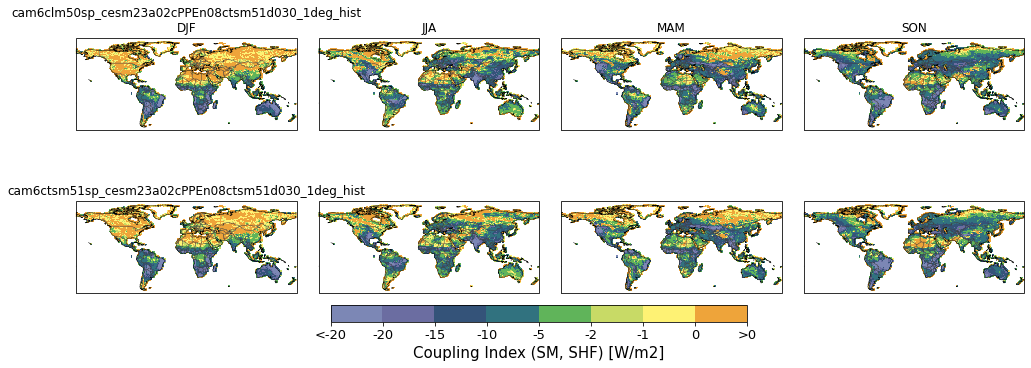

In [90]:
# ------------------------------------
#   Plot terrestrial leg of CI (SM,SHF)
# ------------------------------------

if plt_rawMaps=='true':
    # Set up figure 
    fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                            facecolor='w', edgecolor='k',
                            subplot_kw={'projection':ccrs.PlateCarree()})
    #Adjust space between subplots 
    fig.subplots_adjust(hspace = -0.4,wspace = 0.1)
    #Put axs handles in array, axs 
    axs = axs.ravel()

#     cmap   = my_cmap_SMvSHF
#     bounds = [-20,-15,-10,-5,-2,1,0]
#     norm   = colors.BoundaryNorm(bounds,cmap.N)
    bounds = [1,2,3,4,5,6,7,8,9]
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    
    iPlot = 0
    for iSeason in range(4):
        axs[iPlot].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
        axs[iPlot].coastlines(linewidth=0.5,edgecolor='0.25')
        axs[iPlot].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
        
        axs[iPlot+4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
        axs[iPlot+4].coastlines(linewidth=0.5,edgecolor='0.25')
        axs[iPlot+4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
        
        # Plot case 1
        cplot = axs[iPlot].pcolormesh(lon,lat,colorsTerraLeg_case1[iSeason,:,:], 
                                      cmap = my_cmap_SMvSHF,
                                      norm = norm,
                                      vmin = min(bounds), vmax=max(bounds))
        
        # Plot case 2
        cplot = axs[iPlot+4].pcolormesh(lon,lat,colorsTerraLeg_case2[iSeason,:,:], 
                                      cmap = my_cmap_SMvSHF,
                                      norm = norm,
                                      vmin = min(bounds), vmax=max(bounds))
        
        if iSeason==1:
            # Add colorbar 
            ax_position = axs[iPlot+4].get_position()
            cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
            cbar = plt.colorbar(cplot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
            cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=15)
            cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=13)  # vertically oriented colorbar

        
        if iSeason==0: 
            axs[iPlot].set_title(case1+'\n'+terraLeg_case1.season.values[iSeason])
            axs[iPlot+4].set_title(case2)
        else:
            axs[iPlot].set_title(terraLeg_case1.season.values[iSeason])
        
        iPlot= iPlot+1
    
    

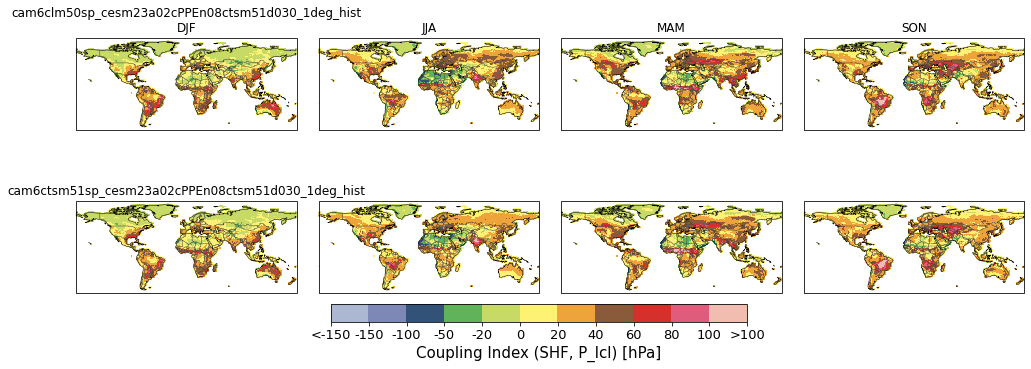

In [89]:
# ------------------------------------
#   Plot atmospheric leg of CI (SM,SHF)
# ------------------------------------

if plt_rawMaps=='true':
    # Set up figure 
    fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                            facecolor='w', edgecolor='k',
                            subplot_kw={'projection':ccrs.PlateCarree()})
    #Adjust space between subplots 
    fig.subplots_adjust(hspace = -0.4,wspace = 0.1)
    #Put axs handles in array, axs 
    axs = axs.ravel()

    bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    
    iPlot = 0
    for iSeason in range(4):
        axs[iPlot].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
        axs[iPlot].coastlines(linewidth=0.5,edgecolor='0.25')
        axs[iPlot].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
  
        axs[iPlot+4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
        axs[iPlot+4].coastlines(linewidth=0.5,edgecolor='0.25')
        axs[iPlot+4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
        
        # Plot case 1
        cplot = axs[iPlot].pcolormesh(lon,lat,colorsAtmoLeg_case1[iSeason,:,:]*landMask, 
                                      cmap = my_cmap_SHFvPlcl,
                                      norm = norm,
                                      vmin = min(bounds), vmax=max(bounds))
        
        # Plot case 2
        cplot = axs[iPlot+4].pcolormesh(lon,lat,colorsAtmoLeg_case2[iSeason,:,:]*landMask, 
                                      cmap = my_cmap_SHFvPlcl,
                                      norm = norm,
                                      vmin = min(bounds), vmax=max(bounds))
        
        if iSeason==1:
            # Add colorbar 
            ax_position = axs[iPlot+4].get_position()
            cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
            cbar = plt.colorbar(cplot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
            cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=15)
            cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=13)  # vertically oriented colorbar
        
        if iSeason==0: 
            axs[iPlot].set_title(case1+'\n'+terraLeg_case1.season.values[iSeason])
            axs[iPlot+4].set_title(case2)
        else:
            axs[iPlot].set_title(terraLeg_case1.season.values[iSeason])
        
        iPlot= iPlot+1
    
    

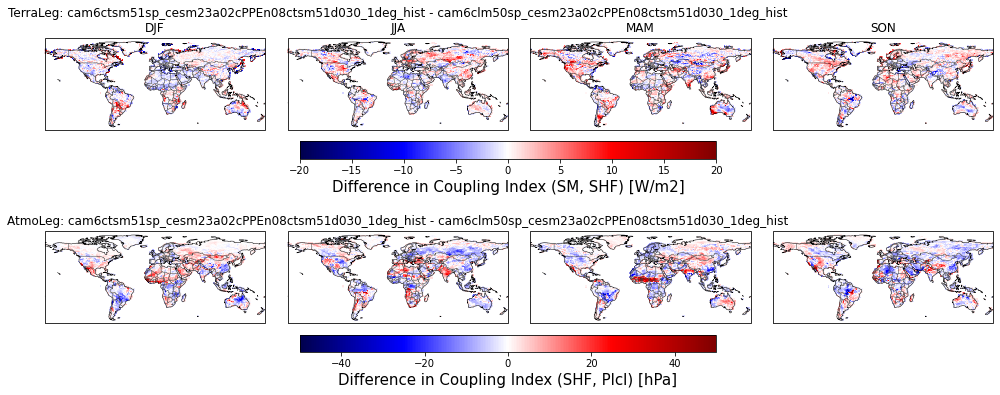

In [95]:
# ------------------------------------
#   Plot difference in CI
# ------------------------------------

if plt_diffMaps=='true':
    # Set up figure 
    fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                            facecolor='w', edgecolor='k',
                            subplot_kw={'projection':ccrs.PlateCarree()})
    #Adjust space between subplots 
    fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
    #Put axs handles in array, axs 
    axs = axs.ravel()
    
    diff_terraCI = terraLeg_case2.soilM_10_SHFLX_CI.values - terraLeg_case1.soilM_10_SHFLX_CI.values
    diff_atmoCI  = atmoLeg_case2.SHFLX_Plcl_CI.values      - atmoLeg_case1.SHFLX_Plcl_CI.values
    
    iPlot = 0
    for iSeason in range(4):
        axs[iPlot].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
        axs[iPlot].coastlines(linewidth=0.5,edgecolor='0.25')
        axs[iPlot].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
  
        axs[iPlot+4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
        axs[iPlot+4].coastlines(linewidth=0.5,edgecolor='0.25')
        axs[iPlot+4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
        
        # Plot case 1
        cplot1 = axs[iPlot].pcolormesh(lon,lat,diff_terraCI[iSeason,:,:], 
                                      cmap = 'seismic',
                                      vmin = -20, vmax=20)
        
        # Plot case 2
        cplot2 = axs[iPlot+4].pcolormesh(lon,lat,diff_atmoCI[iSeason,:,:]*landMask, 
                                      cmap = 'seismic',
                                      vmin = -50, vmax=50)
        
        if iSeason==1:
            # Add colorbars
            ax_position = axs[iPlot].get_position()
            cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
            cbar = plt.colorbar(cplot1, orientation='horizontal',cax=cbar_ax)
            cbar.set_label('Difference in Coupling Index (SM, SHF) [W/m2]',fontsize=15)
            
            ax_position = axs[iPlot+4].get_position()
            cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
            cbar = plt.colorbar(cplot2, orientation='horizontal',cax=cbar_ax)
            cbar.set_label('Difference in Coupling Index (SHF, Plcl) [hPa]',fontsize=15)
        
        if iSeason==1: 
            axs[iPlot].set_title('TerraLeg: '+case2+' - '+case1+'\n'+terraLeg_case1.season.values[iSeason])
            axs[iPlot+4].set_title('AtmoLeg: '+case2+' - '+case1)
        else:
            axs[iPlot].set_title(terraLeg_case1.season.values[iSeason])
        
        iPlot= iPlot+1  
    

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


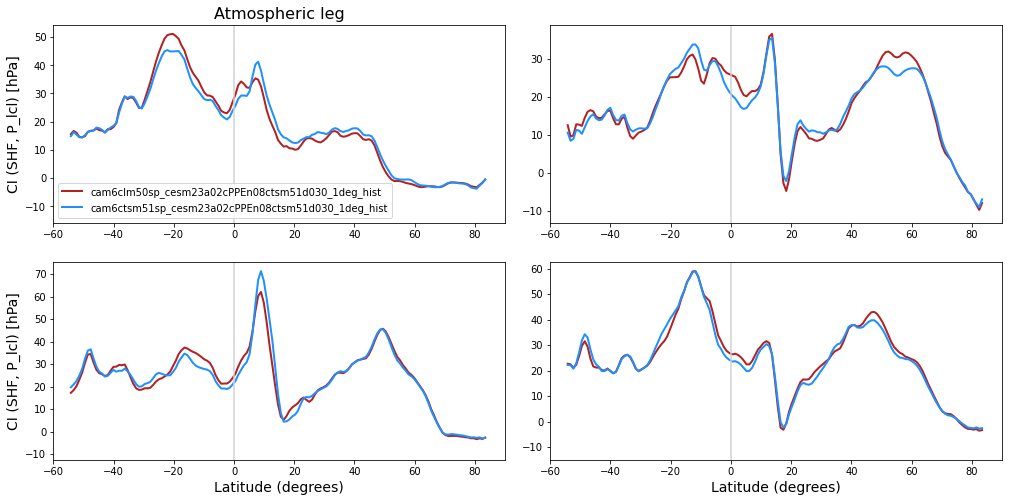

In [104]:
# --------------------------------------------
#   Plot zonal means of CI: Atmospheric leg
# --------------------------------------------

if plt_zonalMeans =='true':

    # Use a simple moving average over latitude to smooth out zonal means
    #  Method here: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
    #  Left centered moving average (i.e., latitude mean assigned to lowest value is mean of that value and next two)

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    
    # Set up figure 
    fig, axs = plt.subplots(2,2, figsize=(17, 8), 
                            facecolor='w', edgecolor='k')
    #Adjust space between subplots 
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    #Put axs handles in array, axs 
    axs = axs.ravel()
    
    for iSeason in range(4):
        lonMean_atmoLeg_case1 = np.nanmean(atmoLeg_case1.SHFLX_Plcl_CI.values[iSeason,:,:]*landMask,axis=1)
        lonMean_atmoLeg_case2 = np.nanmean(atmoLeg_case2.SHFLX_Plcl_CI.values[iSeason,:,:]*landMask,axis=1)

        w = 3    # Number of latitudes to compute window over (~2.5-3˚)
        lonMean_atmoLeg_case1 = moving_average(lonMean_atmoLeg_case1, w)
        lonMean_atmoLeg_case2 = moving_average(lonMean_atmoLeg_case2, w)
        smoothLat = moving_average(lat,w)
        
        axs[iSeason].plot(smoothLat,lonMean_atmoLeg_case1,'firebrick',linewidth=2,label=case1)
        axs[iSeason].plot(smoothLat,lonMean_atmoLeg_case2,'dodgerblue',linewidth=2,label=case2)
        
        axs[iSeason].set_xlim([-60, 90])
        axs[iSeason].axvline(0,color='lightgrey')
        
    axs[0].legend()
        
    axs[2].set_xlabel('Latitude (degrees)',fontsize=14)
    axs[3].set_xlabel('Latitude (degrees)',fontsize=14)
    
    axs[0].set_ylabel('CI (SHF, P_lcl) [hPa]', fontsize=14)
    axs[2].set_ylabel('CI (SHF, P_lcl) [hPa]', fontsize=14)
    
    axs[0].set_title('Atmospheric leg',fontsize=16)



/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


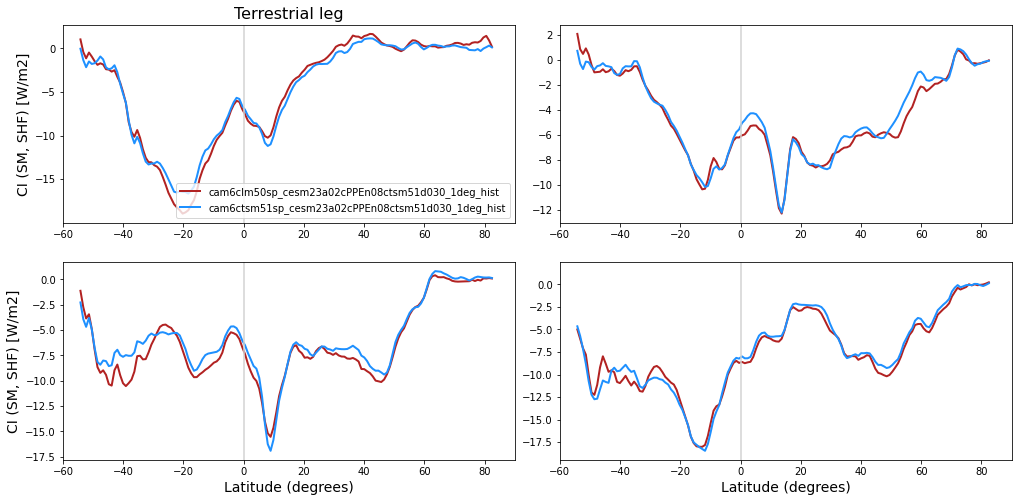

In [105]:
# --------------------------------------------
#   Plot zonal means of CI: Atmospheric leg
# --------------------------------------------

if plt_zonalMeans =='true':

    # Use a simple moving average over latitude to smooth out zonal means
    #  Method here: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
    #  Left centered moving average (i.e., latitude mean assigned to lowest value is mean of that value and next two)

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    
    # Set up figure 
    fig, axs = plt.subplots(2,2, figsize=(17, 8), 
                            facecolor='w', edgecolor='k')
    #Adjust space between subplots 
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    #Put axs handles in array, axs 
    axs = axs.ravel()
    
    for iSeason in range(4):
        lonMean_terraLeg_case1 = np.nanmean(terraLeg_case1.soilM_10_SHFLX_CI.values[iSeason,:,:],axis=1)
        lonMean_terraLeg_case2 = np.nanmean(terraLeg_case2.soilM_10_SHFLX_CI.values[iSeason,:,:],axis=1)

        w = 3    # Number of latitudes to compute window over (~2.5-3˚)
        lonMean_terraLeg_case1 = moving_average(lonMean_terraLeg_case1, w)
        lonMean_terraLeg_case2 = moving_average(lonMean_terraLeg_case2, w)
        smoothLat = moving_average(lat,w)
        
        axs[iSeason].plot(smoothLat,lonMean_terraLeg_case1,'firebrick',linewidth=2,label=case1)
        axs[iSeason].plot(smoothLat,lonMean_terraLeg_case2,'dodgerblue',linewidth=2,label=case2)
        
        axs[iSeason].set_xlim([-60, 90])
        axs[iSeason].axvline(0,color='lightgrey')
        
    axs[0].legend()
        
    axs[2].set_xlabel('Latitude (degrees)',fontsize=14)
    axs[3].set_xlabel('Latitude (degrees)',fontsize=14)
    
    axs[0].set_ylabel('CI (SM, SHF) [W/m2]', fontsize=14)
    axs[2].set_ylabel('CI (SM, SHF) [W/m2]', fontsize=14)
    
    axs[0].set_title('Terrestrial leg',fontsize=16)
